In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from scipy.signal import savgol_filter

In [85]:
folder_rl2 = "../result/gaussv0/rl2/"
dirs_containing_res = os.listdir(folder_rl2)
eval_file_list = []
test_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_rl2 + d + "/eval.pkl")
    test_file_list.append(folder_rl2 + d + "/test.pkl")

In [86]:
def read_file_list(file_list):
    o = []
    for f in file_list:
        objects = []
        with (open(f, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break
        o.append(objects)
    return o

In [87]:
eval_rl2 = read_file_list(eval_file_list)
test_rl2 = read_file_list(test_file_list)

In [88]:
eval_rl2 = np.array(eval_rl2)
eval_rl2 = eval_rl2.reshape(10, 150)

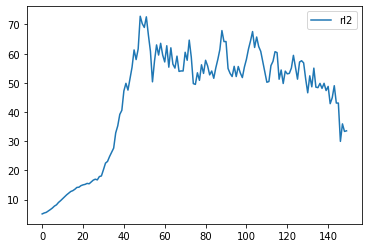

In [89]:
plt.plot(np.mean(eval_rl2, 0), label="rl2")
plt.legend()
plt.show()

In [90]:
test_rl2 = read_file_list(test_file_list)
test_rl2 = np.array(test_rl2)
test_rl2.shape

(10, 1, 150, 1, 10)

# Ours - joint

In [13]:
folder_ours = "../result/gaussv0/ours/joint/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")
    test_file_list.append(folder_ours + d + "/test.pkl")
    vae_file_list.append(folder_ours +d + "/vae.pkl")

In [14]:
eval_ours = read_file_list(eval_file_list)
test_ours = read_file_list(test_file_list)

In [15]:
eval_ours = np.array(eval_ours)
eval_ours.shape

(9, 1, 149)

In [16]:
eval_ours = eval_ours.reshape(9, 149)

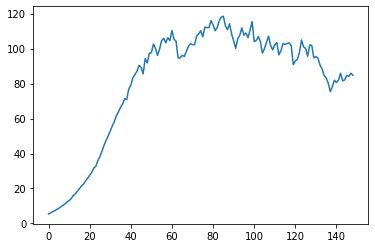

In [17]:
plt.plot(np.mean(eval_ours, 0))

# Ours - Joint lr=0.00005

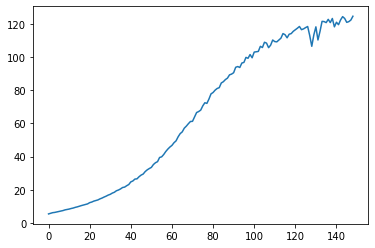

In [48]:
folder_ours = "../result/gaussv0/ours/jointlr00005/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")
    test_file_list.append(folder_ours + d + "/test.pkl")
    vae_file_list.append(folder_ours +d + "/vae.pkl")

eval_ours_joint_lr = read_file_list(eval_file_list)
eval_ours_joint_lr = np.array(eval_ours_joint_lr)
eval_ours_joint_lr = eval_ours_joint_lr.reshape(eval_ours_joint_lr.shape[0], eval_ours_joint_lr.shape[-1])
plt.plot(np.mean(eval_ours_joint_lr, 0))

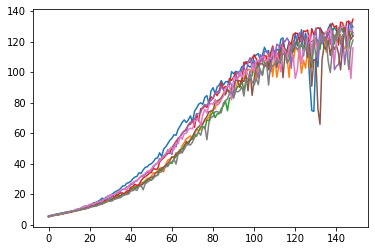

In [69]:
for i in range(8):
    plt.plot(eval_ours_joint_lr[i])


# Ours - smart

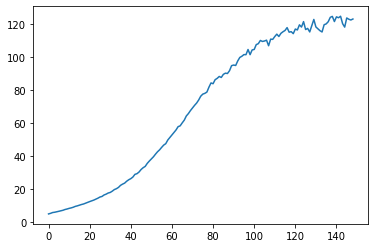

In [92]:
folder_ours = "../result/gaussv0/ours/smart/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")
    test_file_list.append(folder_ours + d + "/test.pkl")
    vae_file_list.append(folder_ours +d + "/vae.pkl")

eval_ours_smart = read_file_list(eval_file_list)
eval_ours_smart = np.array(eval_ours_smart)
eval_ours_smart = eval_ours_smart.reshape(eval_ours_smart.shape[0], eval_ours_smart.shape[-1])
plt.plot(np.mean(eval_ours_smart, 0))

In [95]:
test_ours_smart = np.array(read_file_list(test_file_list))
test_ours_smart[0,0,140,0,0]

126.1877987

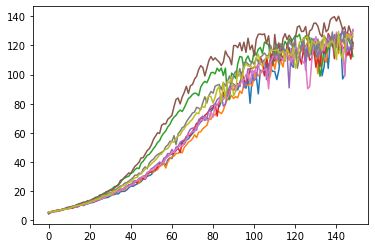

In [64]:
for i in range(9):
    plt.plot(eval_ours_smart[i])

In [54]:
vae_smart = read_file_list(vae_file_list)
vae_smart = np.array(vae_smart)

In [56]:
vae_smart = vae_smart.reshape(9, 15000, 3)

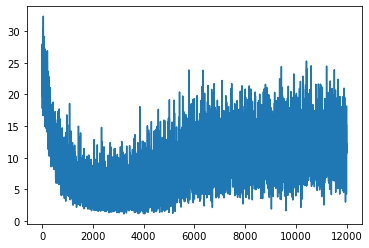

In [63]:
plt.plot(np.mean(vae_smart[:, 3000:, 1], 0))

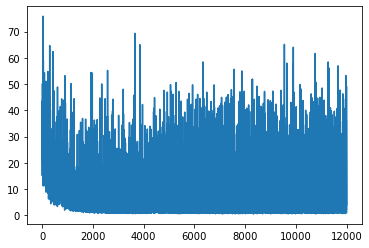

In [156]:
plt.plot(vae_smart[7, 3000:, 1])

# Ours - data

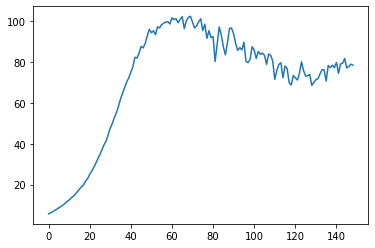

In [20]:
folder_ours = "../result/gaussv0/ours/load/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")
    test_file_list.append(folder_ours + d + "/test.pkl")
    vae_file_list.append(folder_ours +d + "/vae.pkl")

eval_ours_data = read_file_list(eval_file_list)
eval_ours_data = np.array(eval_ours_data)
eval_ours_data = eval_ours_data.reshape(eval_ours_data.shape[0], eval_ours_data.shape[-1])
plt.plot(np.mean(eval_ours_data, 0))

# Posterior TS - data

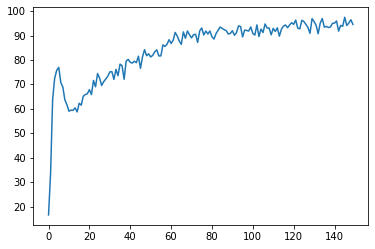

In [39]:
folder_ours = "../result/gaussv0/ts_posterior/data/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval")

eval_ts_data = read_file_list(eval_file_list[1:])
eval_ts_data = np.array(eval_ts_data)
eval_ts_data = eval_ts_data.reshape(eval_ts_data.shape[0], eval_ts_data.shape[-1])
plt.plot(np.mean(eval_ts_data, 0))

# Posterior TS joint

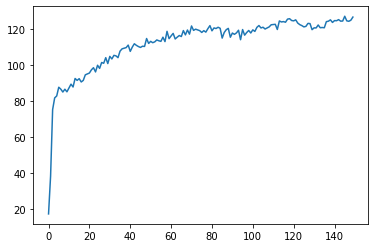

In [46]:
folder_ours = "../result/gaussv0/ts_posterior/joint/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval")

eval_ts_joint = read_file_list(eval_file_list)
eval_ts_joint = np.array(eval_ts_joint)
eval_ts_joint = eval_ts_joint.reshape(eval_ts_joint.shape[0], eval_ts_joint.shape[-1])
plt.plot(np.mean(eval_ts_joint, 0))

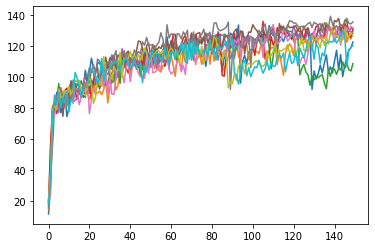

In [65]:
for i in range(eval_ts_joint.shape[0]):
    plt.plot(eval_ts_joint[i])

# ALL

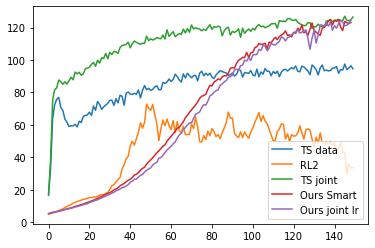

In [53]:
plt.plot(np.mean(eval_ts_data, 0), label="TS data")
plt.plot(np.mean(eval_rl2, 0), label="RL2")
#plt.plot(np.mean(eval_ours, 0), label="Ours joint")
#plt.plot(np.mean(eval_ours_data, 0), label="Ours data")
plt.plot(np.mean(eval_ts_joint, 0), label="TS joint")
plt.plot(np.mean(eval_ours_smart, 0), label="Ours Smart")
plt.plot(np.mean(eval_ours_joint_lr, 0), label="Ours joint lr")
plt.legend()

# Ours - smart - lr=0.00005, vae_lr = def

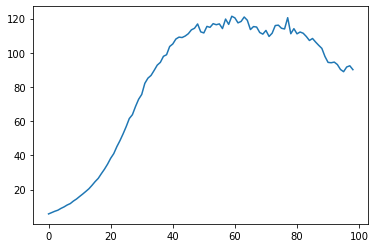

In [147]:
folder_ours = "../result/newgaussv0/ourssmart/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")
    vae_file_list.append(folder_ours + d + "/vae.pkl")

eval_ours_smart = read_file_list(eval_file_list)
eval_ours_smart = np.array(eval_ours_smart)
eval_ours_smart = eval_ours_smart.reshape(eval_ours_smart.shape[0], eval_ours_smart.shape[-1])
plt.plot(np.mean(eval_ours_smart, 0))

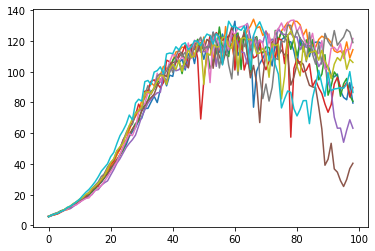

In [148]:
for i in range(10):
    plt.plot(eval_ours_smart[i])

In [137]:
vae_ours = read_file_list(vae_file_list)
vae_ours = np.array(vae_ours)
vae_ours = vae_ours.reshape(10, 25000, 3)

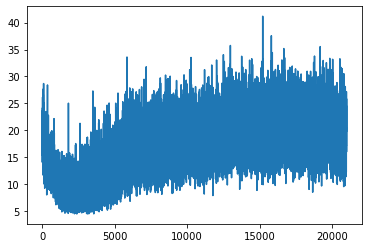

In [143]:
plt.plot(np.mean(vae_ours[:, 4000:, 0], 0))

# Ours - smart - lr=0.00005 vae_lr small

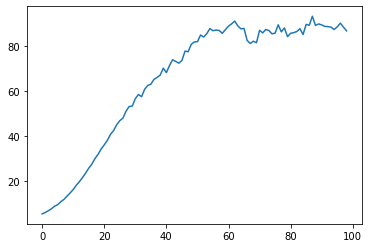

In [144]:
folder_ours = "../result/newgaussv0/ourssmartvaelr/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")
    vae_file_list.append(folder_ours + d + "/vae.pkl")

eval_ours_smart_lr = read_file_list(eval_file_list)
eval_ours_smart_lr = np.array(eval_ours_smart_lr)
eval_ours_smart_lr = eval_ours_smart_lr.reshape(eval_ours_smart_lr.shape[0], eval_ours_smart_lr.shape[-1])
plt.plot(np.mean(eval_ours_smart_lr, 0))

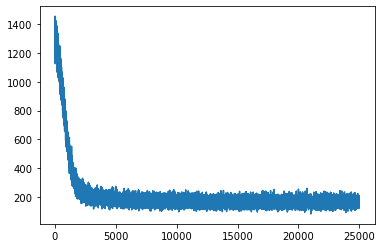

In [146]:
vae_ours = read_file_list(vae_file_list)
vae_ours = np.array(vae_ours)
vae_ours = vae_ours.reshape(10, 25000, 3)
plt.plot(np.mean(vae_ours[:, :, 0], 0))

# TS joint

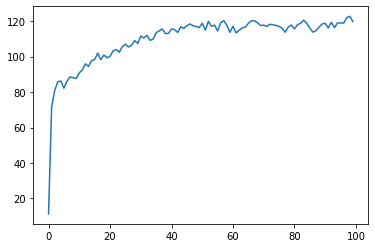

In [116]:
folder_ours = "../result/newgaussv0/tsjoint/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval")

ts_joint = read_file_list(eval_file_list)
ts_joint = np.array(ts_joint)
ts_joint = ts_joint.reshape(ts_joint.shape[0], ts_joint.shape[-1])
plt.plot(np.mean(ts_joint, 0))

# TS - smart

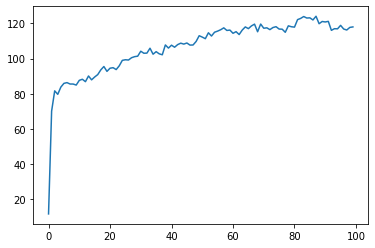

In [120]:
folder_ours = "../result/newgaussv0/tssmart/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval")

ts_smart = read_file_list(eval_file_list)
ts_smart = np.array(ts_smart)
ts_smart = ts_smart.reshape(ts_smart.shape[0], ts_smart.shape[-1])
plt.plot(np.mean(ts_smart, 0))

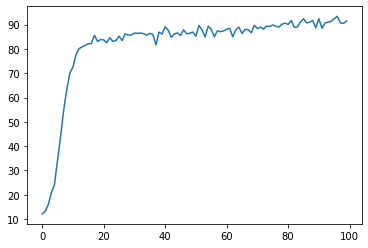

In [124]:
folder_ours = "../result/newgaussv0/tssmartvaelr/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval")

ts_smart_lr = read_file_list(eval_file_list)
ts_smart_lr = np.array(ts_smart_lr)
ts_smart_lr = ts_smart_lr.reshape(ts_smart_lr.shape[0], ts_smart_lr.shape[-1])
plt.plot(np.mean(ts_smart_lr, 0))

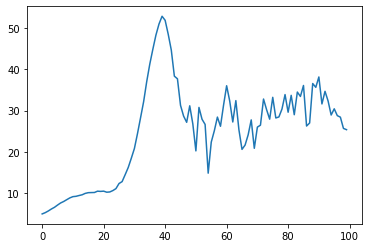

In [189]:
folder_ours = "../result/newgaussv0/rl2/"
dirs_containing_res = os.listdir(folder_ours)
eval_file_list = []
test_file_list = []
vae_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(folder_ours + d + "/eval.pkl")

rl2 = read_file_list(eval_file_list)
rl2 = np.array(rl2)
rl2 = rl2.reshape(rl2.shape[0], rl2.shape[-1])
plt.plot(np.mean(rl2, 0))

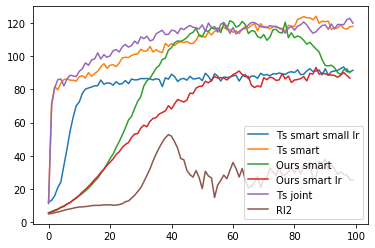

In [161]:
plt.plot(np.mean(ts_smart_lr,0), label="Ts smart small lr")
plt.plot(np.mean(ts_smart, 0), label="Ts smart")
plt.plot(np.mean(eval_ours_smart, 0), label="Ours smart")
plt.plot(np.mean(eval_ours_smart_lr, 0), label="Ours smart lr")
plt.plot(np.mean(ts_joint, 0), label="Ts joint")
plt.plot(np.mean(rl2, 0), label="Rl2")

plt.legend()

In [304]:
def plot_eval(folder_list, label_list):
    assert(len(folder_list) == len(label_list))
    
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        eval_file_list = []
        
        try:
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval.pkl")

            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
            
        except:
            eval_file_list = []
            
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval")

            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
        
        
        a_list.append(e)
    
    for i, label in enumerate(label_list):
        x = np.arange(len(np.mean(a_list[i], 0)))
        
        m = np.mean(a_list[i], 0)
        std = np.std(a_list[i], 0)
        
        plt.plot(x, m, label=label)
        plt.fill_between(x, m - std, m + std, alpha=0.2)
    plt.legend()
    plt.show()
    
    return a_list


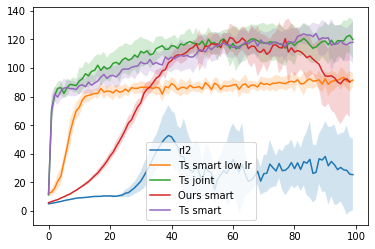

In [306]:
a_list = plot_eval([ "../result/newgaussv0/rl2/", 
                    "../result/newgaussv0/tssmartvaelr/",
                    "../result/newgaussv0/tsjoint/",
                   "../result/newgaussv0/ourssmart/",
                   "../result/newgaussv0/tssmart/"]
                   , ['rl2', 'Ts smart low lr', 'Ts joint', 'Ours smart', 'Ts smart'])

In [326]:
def plot_test_seq(folder_list, seq_idx, has_mode_list, label_list, seqname):
    mode_label_list = ['StdGP', 'NoStdGP', 'TruePrior']
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        test_file_list = []
        
        try:
            for d in dirs_containing_res:
                test_file_list.append(f + d + "/test")
            e = read_file_list(test_file_list)
            e = np.array(e)
            e = e.squeeze(1)
        except:
            test_file_list = []
            
            for d in dirs_containing_res:
                test_file_list.append(f + d + "/test.pkl")

            e = read_file_list(test_file_list)
            e = np.array(e)
            e = e.squeeze(1)
            
        a_list.append(e)
    
    for i, a in enumerate(a_list):
        if has_mode_list[i]:
            for mode in range(3):
                v = a[:, :, mode, seq_idx]
                v = v.tolist()
                v = np.array(v)
                
                m = np.mean(v, (0,2))
                std = np.std(v, (0,2))
                x = np.arange(len(m))
                plt.plot(x, m, label=label_list[i] + " " + mode_label_list[mode])
                plt.fill_between(x, m - std, m + std, alpha=0.2)
        else:
            v = a[:, :, seq]
            v = v.tolist()
            v = np.array(v)
            
            m = np.mean(v, (0, 2))
            std = np.std(v, (0, 2))
            
            x = np.arange(len(m))
            plt.plot(x, m, label=label_list[i])
            plt.fill_between(x, m - std, m + std, alpha=0.2)
            
    plt.title("Sequence {}".format(seqname))
    plt.legend()
    plt.show()

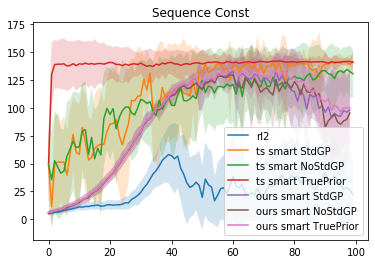

In [329]:
plot_test_seq(["../result/newgaussv0/rl2/", 
               "../result/newgaussv0/tssmart/",
               "../result/newgaussv0/ourssmart/"], 
              seq_idx=0, 
              has_mode_list=[False, True, True], 
              label_list=['rl2', 'ts smart', 'ours smart'], 
              seqname='Const')

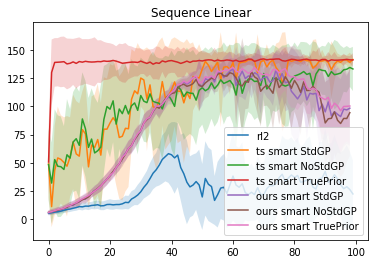

In [330]:
plot_test_seq(["../result/newgaussv0/rl2/", 
               "../result/newgaussv0/tssmart/",
               "../result/newgaussv0/ourssmart/"], 
              seq_idx=1, 
              has_mode_list=[False, True, True], 
              label_list=['rl2', 'ts smart', 'ours smart'], 
              seqname='Linear')

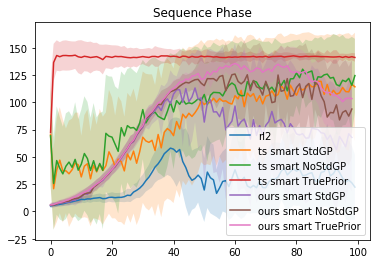

In [331]:
plot_test_seq(["../result/newgaussv0/rl2/", 
               "../result/newgaussv0/tssmart/",
               "../result/newgaussv0/ourssmart/"], 
              seq_idx=2, 
              has_mode_list=[False, True, True], 
              label_list=['rl2', 'ts smart', 'ours smart'], 
              seqname='Phase')

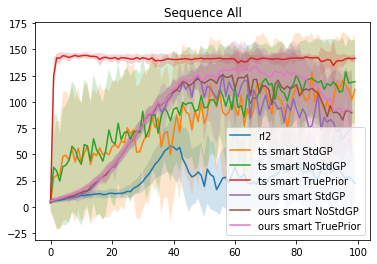

In [332]:
plot_test_seq(["../result/newgaussv0/rl2/", 
               "../result/newgaussv0/tssmart/",
               "../result/newgaussv0/ourssmart/"], 
              seq_idx=3, 
              has_mode_list=[False, True, True], 
              label_list=['rl2', 'ts smart', 'ours smart'], 
              seqname='All')